## TURBOFAN ENGINE RUL PREDICTION LSTM MODEL

After data had been preprocessed, it was then fed into a neural network for training. The data
preprocessing done was; MinMax normalization to put all the values between 0 and 1, sequence
generation, and data labeling. A sequence of length 100 was generated from a matrix of the
values of the training data set features. Fourteen features were selected for training as they
showed a changing trend as the cycles approached the failure point. Also, the six different
conditions along which the engines operate were fed to the neural network.
The data sequences were given an RUL label. This represented the number of cycles to the
failure point. The last cycle before the failure has 0 RUL. The RUL was attached to each cycle
which reduces continuously towards the failure point.

In [1]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers.core import Activation
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import os
from sklearn import preprocessing

In [2]:
# setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED =0

In [3]:
# loading the data to jupyter notebook
index_names =['unit_nr', 'time_cycles']
setting_names= ['Altitude', 'Mach_No', 'TRA']
sensor_names=  ['T2','T24','T30','T50','P2','P15','P30','Nf', 'Nc','epr','Ps30','phi','NRf','NRc'
                ,'BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
col_names= index_names + setting_names + sensor_names
train =pd.read_csv(("train_FD004.txt"), sep= '\s+', header = None, names= col_names)
test= pd.read_csv(("test_FD004.txt"), sep= '\s+', header = None, names= col_names) 
y_test = pd.read_csv(("RUL_FD004.txt"), sep= '\s+', header = None, names= ['RemainingUsefulLife'])

print(train.shape)
train= train.sort_values(['unit_nr', 'time_cycles'])
train.head()

(61249, 26)


,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


labelling the dataset- adding column of RUL

In [4]:
rul = pd.DataFrame(train.groupby('unit_nr')['time_cycles'].max()).reset_index()
rul.columns = ['unit_nr', 'max']
train = train.merge(rul, on=['unit_nr'], how='left')
train['RUL'] = train['max'] - train['time_cycles']
train.drop('max', axis=1, inplace=True)
train.head()

,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [5]:
# adding label columns for the training data
w1 = 30
w0 = 15
train['label1'] = np.where(train['RUL'] <= w1, 1, 0 )
train['label2'] = train['label1']
train.loc[train['RUL'] <= w0, 'label2'] = 2
train.head()

,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,9.3335,0.02,330,2212,100.00,10.62,6.3670,320,0,0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,9.1913,0.02,361,2324,100.00,24.37,14.6552,319,0,0
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,9.4007,0.02,329,2212,100.00,10.48,6.4213,318,0,0
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,9.3369,0.02,328,2212,100.00,10.54,6.4176,317,0,0
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,10.8366,0.02,305,1915,84.93,14.03,8.6754,316,0,0



Applying MinMax normalization to the training dataset

In [6]:
train['cycle_norm'] = train['time_cycles']
cols_normalize = train.columns.difference(['unit_nr','time_cycles','RUL',])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]),
                 columns=cols_normalize,
                 index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train_df)
train = join_df.reindex(columns = train.columns)
train.head()


,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.0,0.288660,0.627907,1.0,0.015473,0.015881,320,0.0,0.0,0.000000
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.0,0.608247,0.864693,1.0,0.477968,0.481487,319,0.0,0.0,0.001845
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.0,0.278351,0.627907,1.0,0.010764,0.018932,318,0.0,0.0,0.003690
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.0,0.268041,0.627907,1.0,0.012782,0.018724,317,0.0,0.0,0.005535
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.0,0.030928,0.000000,0.0,0.130172,0.145560,316,0.0,0.0,0.007380


Applying MinMax normalization to the testing dataset


In [7]:
rul = pd.DataFrame(test.groupby('unit_nr')['time_cycles'].max()).reset_index()
rul.columns = ['unit_nr', 'max']
test = test.merge(rul, on=['unit_nr'], how='left')
test['RUL'] = test['max'] - test['time_cycles']
test.drop('max', axis=1, inplace=True)
test.head()

,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,229
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,228
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,227
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,226
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,225


In [8]:
# adding label columns for the testing data
w1 = 30
w0 = 15
test['label1'] = np.where(test['RUL'] <= w1, 1, 0 )
test['label2'] = test['label1']
test.loc[train['RUL'] <= w0, 'label2'] = 2
test.head()

,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,9.2229,0.02,362,2324,100.00,24.31,14.7007,229,0,0
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,10.8632,0.02,306,1915,84.93,14.36,8.5748,228,0,0
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,9.3960,0.02,328,2212,100.00,10.39,6.4365,227,0,0
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,9.3594,0.02,328,2212,100.00,10.56,6.2367,226,0,0
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,9.3030,0.02,333,2223,100.00,14.85,8.9326,225,0,0


In [9]:
test['cycle_norm'] = test['time_cycles']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]),
                 columns=cols_normalize,
                 index=test.index)
test_join_df = test[test.columns.difference(cols_normalize)].join(norm_test_df)
test = test_join_df.reindex(columns = test.columns)
test = test.reset_index(drop=True)
test.head()


,unit_nr,time_cycles,Altitude,Mach_No,TRA,T2,T24,T30,T50,P2,...,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.476271,0.831354,1.0,0.626985,0.653479,0.643669,0.488507,0.507937,...,0.0,0.618557,0.864693,1.0,0.475950,0.484043,229,0.0,0.0,0.000000
1,1,2,0.595087,0.736342,0.0,0.238089,0.006793,0.036454,0.016957,0.293184,...,0.0,0.041237,0.000000,0.0,0.141271,0.139909,228,0.0,0.0,0.001845
2,1,3,0.999810,1.000000,1.0,0.000000,0.126216,0.263171,0.195653,0.000000,...,0.0,0.268041,0.627907,1.0,0.007736,0.019786,227,0.0,0.0,0.003690
3,1,4,0.999893,0.997862,1.0,0.000000,0.125849,0.262010,0.198967,0.000000,...,0.0,0.268041,0.627907,1.0,0.013454,0.008561,226,0.0,0.0,0.005535
4,1,5,0.833363,0.997625,1.0,0.060269,0.180099,0.298031,0.224282,0.146592,...,0.0,0.319588,0.651163,1.0,0.157753,0.160009,225,0.0,0.0,0.007380


In [10]:
# adding column for max_cycles for test dataset
rul = pd.DataFrame(test.groupby('unit_nr')['time_cycles'].max()).reset_index()
rul.columns = ['unit_nr', 'max']
y_test.columns = ['more']
y_test['unit_nr'] = y_test.index + 1
y_test['max'] = rul['max'] + y_test['more']
y_test.drop('more', axis=1, inplace=True)


In [11]:
# adding RUL for test dataset
test = test.merge(y_test, on=['unit_nr'], how='left')
test['RUL'] = test['max'] - test['time_cycles']
test.drop('max', axis=1, inplace=True)
sequence_length = 100

function that changes the shape features to (samples, time steps, features)

In [12]:
def gen_sequence(id_df, seq_length, seq_cols):

 # putting for all the rows of one engine unit nr in a single matrix
 data_matrix = id_df[seq_cols].values
 num_elements = data_matrix.shape[0]

 for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


In [13]:
# sellecting the feature columns that have atebd and using it to train the model.
sensor_cols = ['Altitude', 'Mach_No', 'TRA','cycle_norm']
sequence_cols = ['T24','T30','T50','P30','Nf',
                'Nc','Ps30','phi','NRf','NRc','BPR','htBleed','W31','W32' ]
sequence_cols.extend(sensor_cols)
val=list(gen_sequence(train[train['unit_nr']==1], sequence_length, sequence_cols))
print(len(val))


221


In [14]:
# generating sequences
# transforming each engine unit nr of the training dataset in a sequence
seq_gen = (list(gen_sequence(train[train['unit_nr']==id], sequence_length, sequence_cols))
 for id in train['unit_nr'].unique())
# generating sequences and converting it to anumpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)


(36349, 100, 18)


In [15]:
# function to create the labels
def gen_labels(id_df, seq_length, label):

 data_matrix = id_df[label].values
 num_elements = data_matrix.shape[0]

 return data_matrix[seq_length:num_elements, :]

In [16]:
# generating the labels
label_gen = [gen_labels(train[train['unit_nr']==id], sequence_length, ['RUL'])
 for id in train['unit_nr'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(36349, 1)

In [17]:
def r2_keras(y_true, y_pred):
 SS_res = K.sum(K.square( y_true - y_pred ))
 SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
 return ( 1 - SS_res/(SS_tot + K.epsilon()) )


Building the neural network

In [18]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features),units=200,return_sequences=True,))
model.add(Dropout(0.35))
model.add(LSTM(units=100,return_sequences=True,))
model.add(Dropout(0.35))
model.add(LSTM(units=100,return_sequences=True,))
model.add(Dropout(0.35))
model.add(LSTM(units=100,return_sequences=True,))
model.add(Dropout(0.35))
model.add(LSTM(units=50,return_sequences=False,))
model.add(Dropout(0.35))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae', 'mse', 'mape',
'msle', r2_keras])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 200)          175200    
                                                                 
 dropout (Dropout)           (None, 100, 200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          120400    
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          8

In [19]:
# defining path to save the nn model
model_path = 'WS100_dropout_repeat.h5'
# fitting the neural network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.2,
verbose=2,

 callbacks = [keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss',
save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
146/146 - 248s - loss: 11439.5918 - mae: 80.7461 - mse: 11439.5918 - mape: 86397888.0000 - msle: 3.7300 - r2_keras: -1.2604e+00 - val_loss: 8759.1172 - val_mae: 70.7316 - val_mse: 8759.1172 - val_mape: 119474344.0000 - val_msle: 2.5279 - val_r2_keras: -2.0741e+00 - 248s/epoch - 2s/step
Epoch 2/100
146/146 - 306s - loss: 10262.2871 - mae: 74.7368 - mse: 10262.2871 - mape: 138617920.0000 - msle: 2.3110 - r2_keras: -1.0251e+00 - val_loss: 7803.9917 - val_mae: 65.5653 - val_mse: 7803.9917 - val_mape: 172076128.0000 - val_msle: 1.8115 - val_r2_keras: -1.6600e+00 - 306s/epoch - 2s/step
Epoch 3/100
146/146 - 320s - loss: 9257.3428 - mae: 69.8116 - mse: 9257.3428 - mape: 187535600.0000 - msle: 1.7429 - r2_keras: -8.2475e-01 - val_loss: 6957.2261 - val_mae: 61.1589 - val_mse: 6957.2261 - val_mape: 224665216.0000 - val_msle: 1.4365 - val_r2_keras: -1.3116e+00 - 320s/epoch - 2s/step
Epoch 4/100
146/146 - 306s - loss: 8377.4561 - mae: 65.7415 - mse: 8377.4561 - mape: 238445152.0000 - m

Epoch 29/100
146/146 - 295s - loss: 5416.5771 - mae: 57.5877 - mse: 5416.5771 - mape: 565261376.0000 - msle: 1.5654 - r2_keras: -6.8445e-02 - val_loss: 4074.8916 - val_mae: 51.7989 - val_mse: 4074.8916 - val_mape: 645146112.0000 - val_msle: 1.2651 - val_r2_keras: -8.8124e-01 - 295s/epoch - 2s/step
Epoch 30/100
146/146 - 306s - loss: 5197.8369 - mae: 56.8541 - mse: 5197.8374 - mape: 610391616.0000 - msle: 1.2551 - r2_keras: -2.2656e-02 - val_loss: 4084.9180 - val_mae: 51.9970 - val_mse: 4084.9180 - val_mape: 651853824.0000 - val_msle: 1.2741 - val_r2_keras: -9.0831e-01 - 306s/epoch - 2s/step
Epoch 31/100
146/146 - 315s - loss: 5218.7769 - mae: 56.7828 - mse: 5218.7764 - mape: 597498624.0000 - msle: 1.2461 - r2_keras: -2.7091e-02 - val_loss: 4070.7253 - val_mae: 51.7080 - val_mse: 4070.7253 - val_mape: 641945216.0000 - val_msle: 1.2608 - val_r2_keras: -8.6870e-01 - 315s/epoch - 2s/step
Epoch 32/100
146/146 - 319s - loss: 5223.1562 - mae: 57.0657 - mse: 5223.1562 - mape: 610862528.0000 - 

Epoch 57/100
146/146 - 527s - loss: 2194.8154 - mae: 31.7027 - mse: 2194.8154 - mape: 113421568.0000 - msle: 0.3832 - r2_keras: 0.5687 - val_loss: 1587.6836 - val_mae: 27.0137 - val_mse: 1587.6836 - val_mape: 64237160.0000 - val_msle: 0.2590 - val_r2_keras: 0.4739 - 527s/epoch - 4s/step
Epoch 58/100
146/146 - 534s - loss: 2179.4365 - mae: 31.5529 - mse: 2179.4365 - mape: 119509552.0000 - msle: 0.3938 - r2_keras: 0.5723 - val_loss: 1595.4648 - val_mae: 27.3638 - val_mse: 1595.4648 - val_mape: 111321512.0000 - val_msle: 0.3139 - val_r2_keras: 0.4559 - 534s/epoch - 4s/step
Epoch 59/100
146/146 - 544s - loss: 2092.4067 - mae: 30.7147 - mse: 2092.4067 - mape: 105426672.0000 - msle: 0.3588 - r2_keras: 0.5891 - val_loss: 1293.9521 - val_mae: 25.0781 - val_mse: 1293.9521 - val_mape: 133470848.0000 - val_msle: 0.3346 - val_r2_keras: 0.5520 - 544s/epoch - 4s/step
Epoch 60/100
146/146 - 454s - loss: 2012.2443 - mae: 30.0603 - mse: 2012.2443 - mape: 114814824.0000 - msle: 0.3627 - r2_keras: 0.6061

Epoch 86/100
146/146 - 289s - loss: 1135.8446 - mae: 22.3482 - mse: 1135.8446 - mape: 94795536.0000 - msle: 0.2640 - r2_keras: 0.7749 - val_loss: 1309.6017 - val_mae: 23.0693 - val_mse: 1309.6017 - val_mape: 89720824.0000 - val_msle: 0.2440 - val_r2_keras: 0.5538 - 289s/epoch - 2s/step
Epoch 87/100
146/146 - 290s - loss: 1047.7745 - mae: 21.4762 - mse: 1047.7745 - mape: 85556880.0000 - msle: 0.2451 - r2_keras: 0.7947 - val_loss: 1326.8848 - val_mae: 24.7506 - val_mse: 1326.8848 - val_mape: 101242800.0000 - val_msle: 0.2773 - val_r2_keras: 0.4134 - 290s/epoch - 2s/step
Epoch 88/100
146/146 - 292s - loss: 1537.1056 - mae: 25.3564 - mse: 1537.1056 - mape: 155858016.0000 - msle: 0.3612 - r2_keras: 0.6992 - val_loss: 3354.1780 - val_mae: 47.0132 - val_mse: 3354.1780 - val_mape: 198193760.0000 - val_msle: 0.7551 - val_r2_keras: -9.7380e-01 - 292s/epoch - 2s/step
Epoch 89/100
146/146 - 291s - loss: 3588.5007 - mae: 43.3493 - mse: 3588.5007 - mape: 418430592.0000 - msle: 0.8634 - r2_keras: 0.2

In [20]:
# listing all the data in history
print(history.history.keys())


dict_keys(['loss', 'mae', 'mse', 'mape', 'msle', 'r2_keras', 'val_loss', 'val_mae', 'val_mse', 'val_mape', 'val_msle', 'val_r2_keras'])


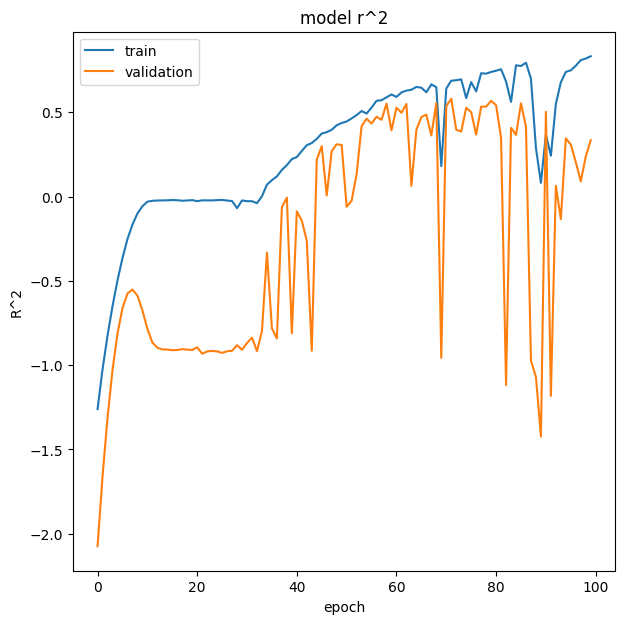

In [21]:
# plotting history for R^2
fig_acc = plt.figure(figsize=(7, 7))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")


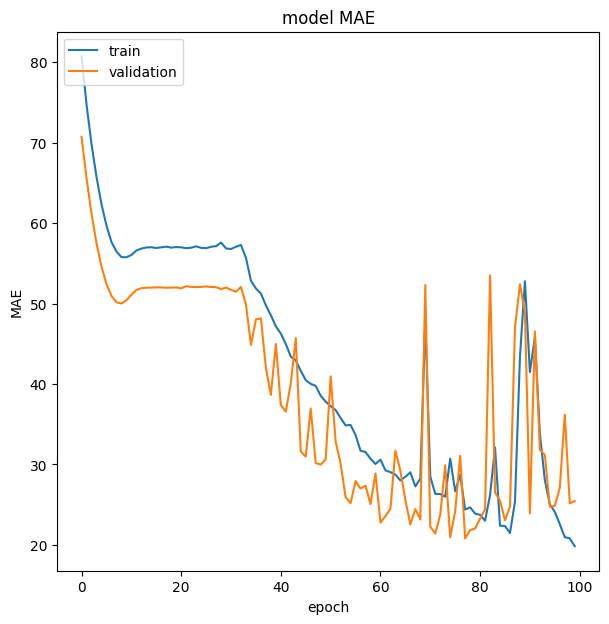

In [22]:
# plotting history for MAE
fig_acc = plt.figure(figsize=(7, 7))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")


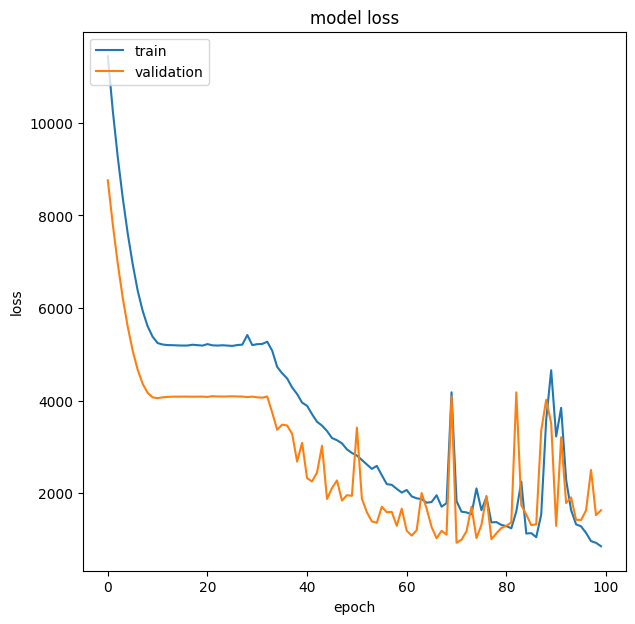

In [23]:
#plotting history for Loss
fig_acc = plt.figure(figsize=(7, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


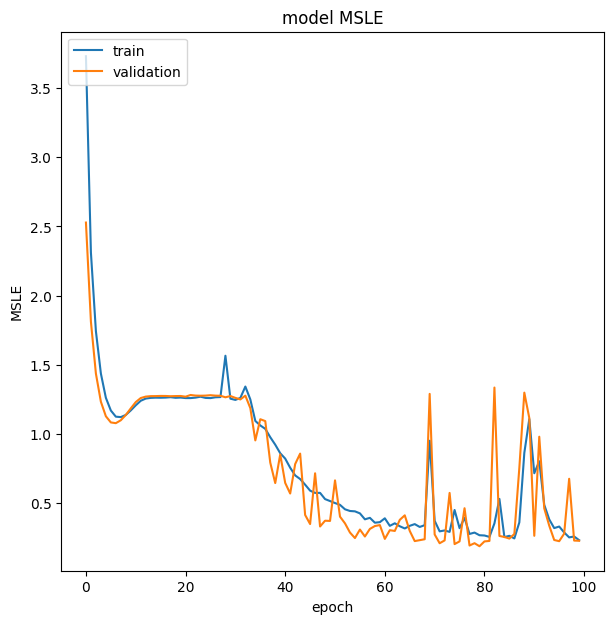

In [24]:
#plotting history for MSLE
fig_acc = plt.figure(figsize=(7, 7))
plt.plot(history.history['msle'])
plt.plot(history.history['val_msle'])
plt.title('model MSLE')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_msle.png")

In [30]:
# the training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nMSE: {}'.format(scores[2]))
print('\nMAPE: {}'.format(scores[3]))
print('\nMSLE: {}'.format(scores[4]))
print('\nR^2: {}'.format(scores[5]))

182/182 [==============================] - 92s 503ms/step - loss: 777.4905 - mae: 17.3916 - mse: 777.4905 - mape: 67679928.0000 - msle: 0.1712 - r2_keras: 0.7446

MAE: 17.39157485961914

MSE: 777.4905395507812

MAPE: 67679928.0

MSLE: 0.17117924988269806

R^2: 0.7446494698524475


In [31]:
rmse = np.sqrt(scores[2])
print(rmse)
test_set = pd.DataFrame(y_test)
test_set.to_csv('submit_train_100dr_repeat.csv', index = None)


27.883517345392086


In [32]:
#picking the last sequence for each unit nr in the test dataset
seq_array_test_last = [test[test['unit_nr']==id][sequence_cols].values[-sequence_length:]
 for id in test['unit_nr'].unique() if len(test[test['unit_nr']==id]) >=
sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print(seq_array_test_last)
print(seq_array_test_last.shape)


[[[0.6307142  0.6724003  0.6466915  ... 0.2969121  1.         0.2398524 ]
  [0.1242886  0.2550698  0.19505224 ... 0.9976247  1.         0.24169742]
  [0.12190197 0.27378285 0.22613186 ... 0.997981   1.         0.24354243]
  ...
  [0.12823573 0.29762644 0.25286418 ... 0.9997625  1.         0.4188192 ]
  [0.12823573 0.30688846 0.2527681  ... 0.9976247  1.         0.42066422]
  [0.02001102 0.05843437 0.05281614 ... 0.73800474 0.         0.42250922]]

 [[0.65981275 0.61820537 0.51903445 ... 0.83230406 1.         0.09778598]
  [0.18147604 0.3283018  0.23931788 ... 0.9976247  1.         0.099631  ]
  [0.63658893 0.6845246  0.67128617 ... 0.2969121  1.         0.10147601]
  ...
  [0.01606389 0.06143169 0.06910051 ... 0.7363421  0.         0.27675277]
  [0.00881219 0.05608511 0.06163084 ... 0.73693585 0.         0.27859777]
  [0.1329172  0.30075878 0.26211122 ... 0.9976247  1.         0.2804428 ]]

 [[0.12043326 0.26743716 0.22826949 ... 0.9976247  1.         0.07564576]
  [0.6559574  0.625577

In [33]:
#picking the labels
y_mask = [len(test[test['unit_nr']==id]) >= sequence_length for id in test['unit_nr'].unique()]
label_array_test_last = test.groupby('unit_nr')['RUL'].nth(-1)[y_mask].values
label_array_test_last =label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print(label_array_test_last)
estimator_one = load_model(model_path,custom_objects={'r2_keras': r2_keras})
y_pred_test = estimator_one.predict(seq_array_test_last)
y_true_test = label_array_test_last
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test_100 dr.csv', index = None)


(188, 1)
[[ 22.]
 [ 39.]
 [107.]
 [ 75.]
 [ 78.]
 [ 14.]
 [ 99.]
 [  7.]
 [ 71.]
 [105.]
 [ 12.]
 [160.]
 [162.]
 [104.]
 [ 82.]
 [ 91.]
 [ 11.]
 [ 26.]
 [142.]
 [ 39.]
 [ 76.]
 [ 64.]
 [118.]
 [  6.]
 [ 22.]
 [147.]
 [126.]
 [ 36.]
 [ 73.]
 [ 89.]
 [ 11.]
 [151.]
 [ 10.]
 [ 97.]
 [ 30.]
 [ 42.]
 [ 60.]
 [ 34.]
 [ 45.]
 [ 24.]
 [ 86.]
 [119.]
 [157.]
 [ 67.]
 [ 97.]
 [  8.]
 [139.]
 [ 51.]
 [ 33.]
 [184.]
 [ 46.]
 [ 12.]
 [ 46.]
 [ 46.]
 [ 12.]
 [ 33.]
 [ 15.]
 [176.]
 [ 23.]
 [ 89.]
 [124.]
 [ 25.]
 [ 74.]
 [ 78.]
 [114.]
 [ 10.]
 [172.]
 [115.]
 [ 70.]
 [ 94.]
 [ 56.]
 [ 86.]
 [ 96.]
 [ 50.]
 [ 73.]
 [154.]
 [129.]
 [171.]
 [ 71.]
 [ 37.]
 [  7.]
 [ 13.]
 [ 22.]
 [  9.]
 [100.]
 [107.]
 [ 41.]
 [153.]
 [ 59.]
 [ 18.]
 [ 13.]
 [ 14.]
 [ 13.]
 [  8.]
 [109.]
 [137.]
 [ 41.]
 [192.]
 [ 23.]
 [ 86.]
 [ 15.]
 [126.]
 [120.]
 [165.]
 [101.]
 [116.]
 [ 36.]
 [  7.]
 [159.]
 [ 88.]
 [146.]
 [ 53.]
 [ 59.]
 [ 56.]
 [145.]
 [ 76.]
 [ 57.]
 [ 31.]
 [ 88.]
 [173.]
 [ 34.]
 [  7.]
 [172.]
 [  6.]

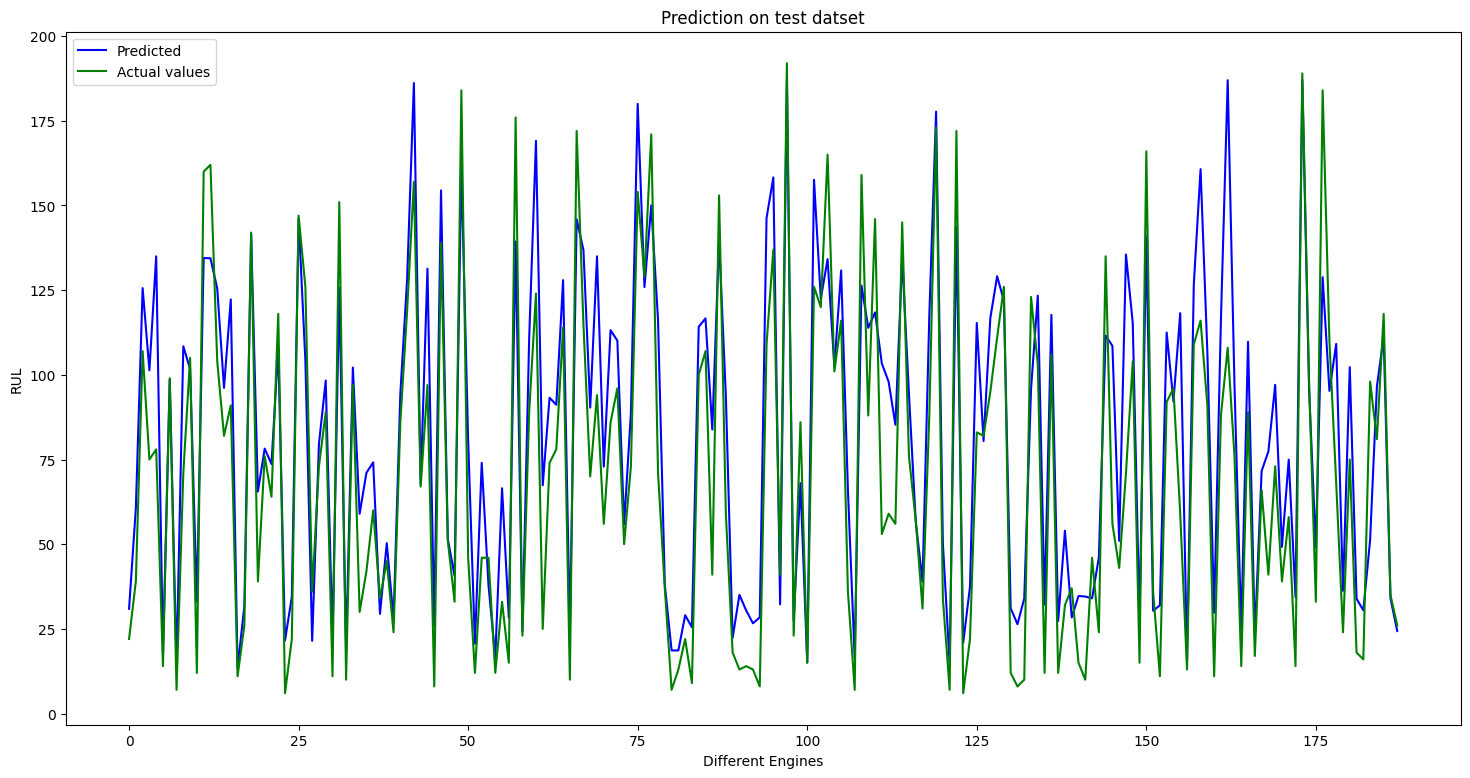

In [34]:
# Plotting in blue color the prediction and in green color the actual RUL to check visually the accuracyof the Trained model.
fig_verify = plt.figure(figsize=(18, 9))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('Prediction on test datset')
plt.ylabel('RUL')
plt.xlabel('Different Engines')
plt.legend(['Predicted', 'Actual values'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")